In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as sr
import os 
from pydub import AudioSegment 
from pydub.silence import split_on_silence, detect_nonsilent

In [30]:
# a function that splits the audio file into chunks on each silence interval
# and applies speech recognition 
def silence_based_conversion(path): 
  
    # open the audio file stored in 
    # the local system as a wav file. 
    print("openning audio file...")
    audio = AudioSegment.from_file(path, format="mp4")
    # audio = AudioSegment.from_wav(path) 
    print("audio file opened")
  
    # open a file where we will concatenate   
    # and store the recognized text 
    fh = open("recognized_text.txt", "w+") 
          
    print("splitting audio file...")
    # split track where silence is 1 seconds  
    # or more and get chunks 

    min_silence_len = 1000
    silence_thresh = -45

    not_silence_ranges = detect_nonsilent(audio, min_silence_len, silence_thresh, 1)

    chunks = []
    for i in range(len(not_silence_ranges)): 
        start_i, end_i =  not_silence_ranges[i][0], not_silence_ranges[i][1]
        
        if i < len(not_silence_ranges) - 1:
            next_start_i = not_silence_ranges[i+1][0]
            end_i = next_start_i - 100
        
        if start_i > 100:
            start_i -= 100
        
        chunks.append(audio[start_i:end_i])
    
    print("audio file splitted, ", end='')
    print("number of chunks: ", len(chunks), "\n")


    # create a directory to store the audio chunks. 
    try: 
        os.mkdir('audio_chunks')
    except(FileExistsError): 
        pass
  
    word_count = 0
    current_time = 0
    timestamps = []  # contains word_count : current time
    
    # process each chunk 
    i = 0
    for chunk in chunks: 
        
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 500) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        # print("saving chunk{0}.wav".format(i)) 
        
        # the name of the newly created chunk 
        filename = "../../data/audio_chunks/chunk{0}.wav".format(i)
        
        # specify the bitrate to be 192 k 
        audio_chunk.export(filename, bitrate ='192k', format ="wav") 

        print("Processing chunk " + str(i) + ", length: " + str(round(chunk.duration_seconds, 2)) + " (s)") 

        # create a speech recognition object 
        r = sr.Recognizer() 
        
        current_time += chunk.duration_seconds
        
        # recognize the chunk 
        with sr.AudioFile(filename) as source: 
            audio_listened = r.listen(source)

        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            
            num_of_words = len(rec.split(' '))
            word_count += num_of_words
            timestamps.append((word_count, current_time))
            
            # write the output to the file. 
            #fh.write(rec+". ") 
            fh.write(rec + '\n') 

        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 

        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 

        i += 1
        
    fh.close()
    print("\n" + "all chunks processed" + "\n")
    
    return timestamps
  

In [31]:
def get_VAD_dictionary():
    """
    This function loads dictionary of 20_000 words, each labeled for arousal, valence and dominance
    :return: Pandas dataframe containing dictionary
    """
    filepath = "../../data/NRC-VAD-Lexicon.txt"
    vad_dict = pd.read_csv(filepath,  names=["valence", "arousal", "dominance"], skiprows=45, sep='\t')
    # print(vad_dict.head(5))
    print("Number of words in dictionary: ", len(vad_dict))
    return vad_dict

In [32]:
def get_vad_scores(text, vad_dict):
    """
    Tries to find words from VAD dictionary in text String. 
    :param text: Text.
    :param vad_dict: Pandas dataframe.
    :return: Dictionary of words from text file, containing VAD scores (valance, arousal, dominance) for each of them
    """
    scores = []
    text = text.replace('\n', ' ')
    text = text.lower()
    words = text.split(' ')
    found_counter = 0
    for w in words:
        try:
            value = vad_dict.loc[w]
            scores.append([w, round(value[0], 2), round(value[1], 2), round(value[2], 2)])
            found_counter += 1
        except KeyError:
            pass
            scores.append([w, 0.5, 0.5, 0.5])

    # print('\n'.join(str(element) for element in scores))
    vad = [score[1:] for score in scores]
    print("number of words in recognised text: ", len(words))
    print("number of words found: ", found_counter)
    return vad

In [33]:
def moving_average(a, n=30) :
    """
    This is just to smooth/average the graph. 
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



def assign_pseudo_timestamps(data, timestamps_list):
    data_with_time = []
    last_word_index = 0
    for i in range(len(timestamps_list)):
        current_word_index = timestamps_list[i][0]
        current_time = timestamps_list[i][1]

        time_diff = current_time - timestamps_list[i-1][1] if i>0 else current_time

        num_of_words_in_interval = (current_word_index - last_word_index)
        for j in range(last_word_index, current_word_index):
            timestamp = current_time + (time_diff / num_of_words_in_interval * (j - last_word_index))
            timestamp /= 60
            timestamp = round(timestamp, 2)
            data_with_time.append([timestamp, data[j][0], data[j][1], data[j][2]])
            
        last_word_index = current_word_index
    
    return data_with_time
    

In [34]:
def main():
    
    # recognize speech and save it to txt file
    # silence_based_conversion("../data/lectures/test2.wav")
    # timestamps = silence_based_conversion("../data/Leonardo DiCaprios Powerful Climate Summit Speech.wav")
    timestamps = silence_based_conversion("../../data/vid2_short.mp4")
    
    # for word, time in timestamps:
    #     print(word, ": ",  time)
    
    # load speech text
    with open("recognized_text.txt", "r") as file:
        text = file.read()
        
    print()
    print(text)
    print()
    
    # load VAD dictionary from csv
    vad_dict = get_VAD_dictionary()
    
    # find words from dictionary in speech text
    vad_scores = get_vad_scores(text, vad_dict)
    
    vac_scores_with_timestamps = assign_pseudo_timestamps(vad_scores, timestamps)
    
    # convert to numpy array
    data = np.array(vac_scores_with_timestamps)


    # plot graphs
    timestamps =  data[:, 0]
    timestamps = moving_average(timestamps)
    
    
    valance = data[:, 1]
    plt.figure(figsize=(15,8))
    plt.plot(valance)
    plt.title("real valance")
    plt.show()
    
    smoothed = moving_average(valance)
    #plt.locator_params(axis="x", tight=False, nbins=20)
    plt.figure(figsize=(15,8))
    plt.plot(timestamps, smoothed)
    plt.title("valance smoothed")
    plt.xlabel("time (minutes)")
    plt.ylabel("score")
    plt.show()
    
    arousal = data[:, 2]
    smoothed = moving_average(arousal)
    plt.figure(figsize=(15,8))
    plt.locator_params(axis="x", tight=False, nbins=20)
    plt.plot(timestamps, smoothed)
    plt.title("arousal smoothed")
    plt.xlabel("time (minutes)")
    plt.ylabel("score")
    plt.show()
    
    dominance = data[:, 3]
    smoothed = moving_average(dominance)
    plt.figure(figsize=(15,8))
    plt.plot(timestamps, smoothed)
    plt.title("dominance smoothed")
    plt.xlabel("time (minutes)")
    plt.ylabel("score")
    plt.show()

openning audio file...
audio file opened
splitting audio file...
audio file splitted, number of chunks:  6 

Processing chunk 0, length: 43.41 (s)
Processing chunk 1, length: 28.09 (s)
Processing chunk 2, length: 4.43 (s)
Processing chunk 3, length: 20.14 (s)
Processing chunk 4, length: 41.48 (s)
Processing chunk 5, length: 54.66 (s)

all chunks processed


imagine you're standing on a street anywhere in America and a Japanese man comes up to you and says excuse me what is the name of this block I'm sorry
play imagine you're standing on a street anywhere in Japan you turn to a person next to you and say excuse me what is the name of this street and they say that Block 17 and 16 and you say okay but what is the name of this street I say will Street don't have names blocks have names just look at Google Maps here there's black 14 15 16 17 18 19 all of these blocks have names in the streets are just the spaces in between the blocks
how do you say okay then how do you know your home addres

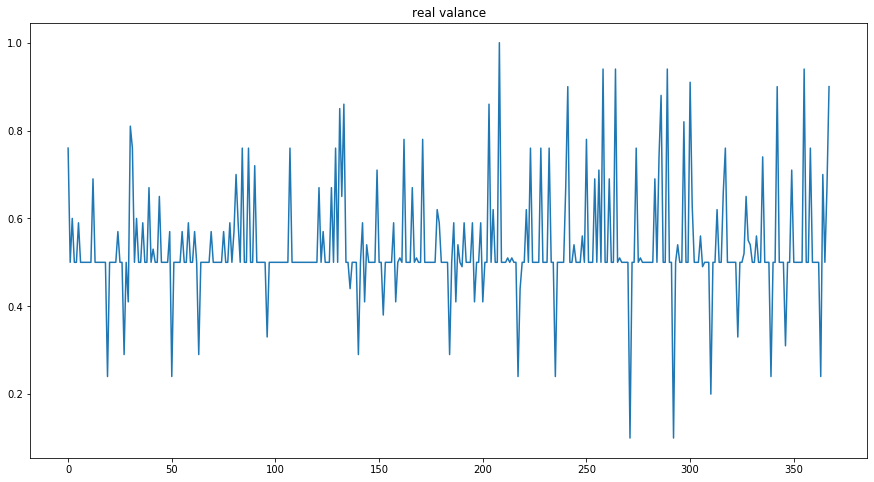

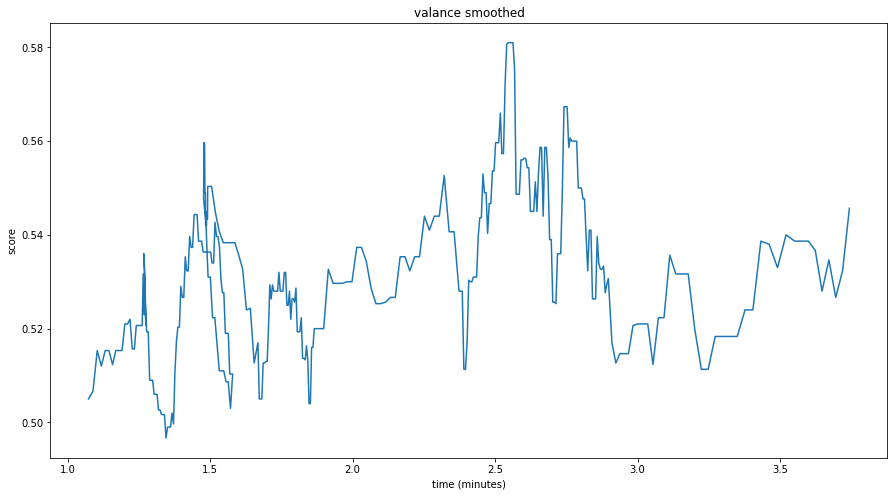

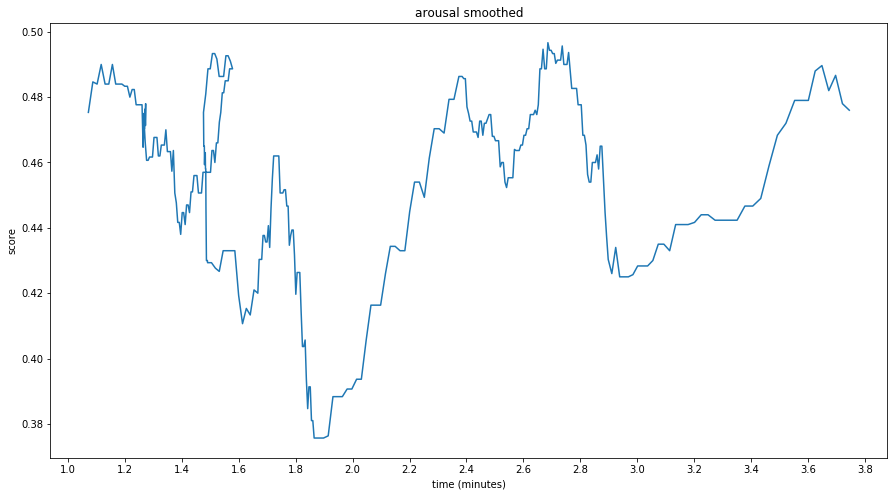

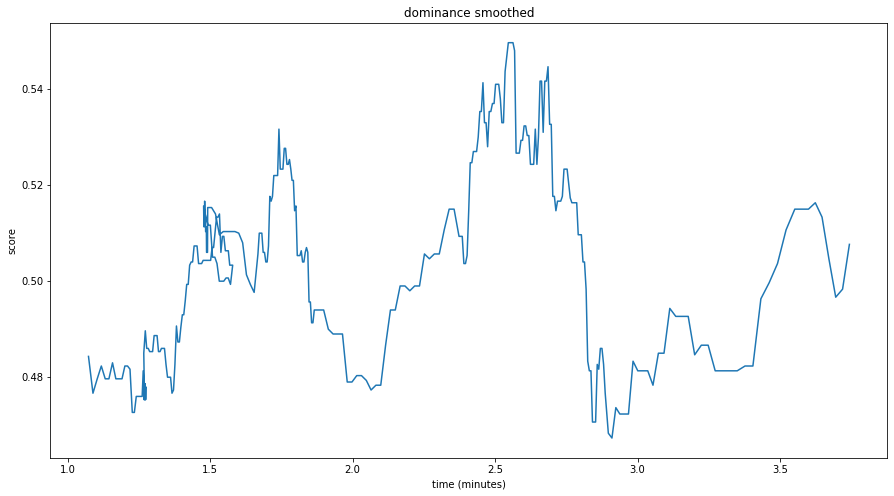

In [35]:
main()
